In [33]:
import pandas as pd
import numpy as np

In [34]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from itertools import combinations
from scipy.stats import chi2_contingency
from scipy.stats import norm
from sklearn.model_selection import GridSearchCV
import seaborn as sn

<h1> Looking at wine data quality from physicochemical properties</h1>

## TOC:
* [Loading and inspecting the data set](#loading-inspecting)
* [Selectiong a Model](#model-selection)
* [Hyperparameter tuning](#parameter-tuning)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"></div>

Introduction and light description

# Loading and inspecting the data set
<a class="anchor" id="loading-inspecting"></a>

In [35]:
df = pd.read_csv('./data.csv')

## Taking a look at the data 

In [36]:
print("Shape of data:", df.shape)
print(df.info())
df.head()

Shape of data: (1143, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB
None


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


## Performing some basic checks on the data

In [37]:
bld = "\033[1m"
end_bld = "\033[0m" 

#Existing quality values in the data
print("Checking data quality..")
print(bld+"Number of variable null valuess:"+end_bld)
print(df.isnull().sum())
print(bld+"\nNumber of duplicate entries:"+end_bld, df.duplicated().sum())

# Calculate basic statistics
statistics = df.describe()
print(statistics)

print("\n\nLooking at the output values... column 'quality'")
unique_classes = df["quality"].unique()
print(bld+"Unique quality values:"+end_bld,unique_classes)
print(bld+"Instance count of quality values:"+end_bld)
print(df["quality"].value_counts())


Checking data quality..
Number of variable null valuess:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
Id                      0
dtype: int64

Number of duplicate entries: 0
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1143.000000       1143.000000  1143.000000     1143.000000   
mean        8.311111          0.531339     0.268364        2.532152   
std         1.747595          0.179633     0.196686        1.355917   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.392500     0.090000        1.900000   
50%         7.900000          0.520000     0.250000        2.200000   
75%         9.100000          0.640000     0.420000        2.60

## Preparing the data for analysis

In [38]:
print("Preparing the 'data' with:")
print("Replacing the quality variable with a string for easy classification")
data = df
data["quality"] = data["quality"].astype(str)

print("Drop the wine Id column")
data = data.drop(columns=["Id"])

Preparing the 'data' with:
Replacing the quality variable with a string for easy classification
Drop the wine Id column


# Testing different models on the data
<a class="anchor" id="model-selection"></a>

In [39]:
#Split the data into test and training sets
test_size = 0.4
train, test = train_test_split(data, test_size=test_size) 

In [40]:
#Split the data into inputs and outputs
def input_and_outputs(data_in, y_col="quality"):
    return data_in.loc[:, data_in.columns != y_col], data_in.loc[:, y_col]

X_values, y_values = input_and_outputs(data)
X_train, y_train = input_and_outputs(train)
X_test, y_test = input_and_outputs(test)

##### An intersting look at the data to see if it splits into 6 different groups
Using clustering I would like to see if this matches the quality predictions in future

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0          0.195153          0.018460     0.000000        0.050107   0.002004   
1          0.107231          0.012098     0.000000        0.035744   0.001347   
2          0.135375          0.013190     0.000694        0.039918   0.001597   
3          0.174177          0.004354     0.008709        0.029548   0.001166   
4          0.194076          0.018359     0.000000        0.049830   0.001993   
...             ...               ...          ...             ...        ...   
1138       0.003955          0.000320     0.000082        0.001444   0.000048   
1139       0.004267          0.000389     0.000050        0.001192   0.000043   
1140       0.003887          0.000376     0.000050        0.001254   0.000056   
1141       0.003696          0.000345     0.000063        0.001378   0.000039   
1142       0.003692          0.000404     0.000075        0.001252   0.000047   

      free sulfur dioxide  

KeyError: 'X'

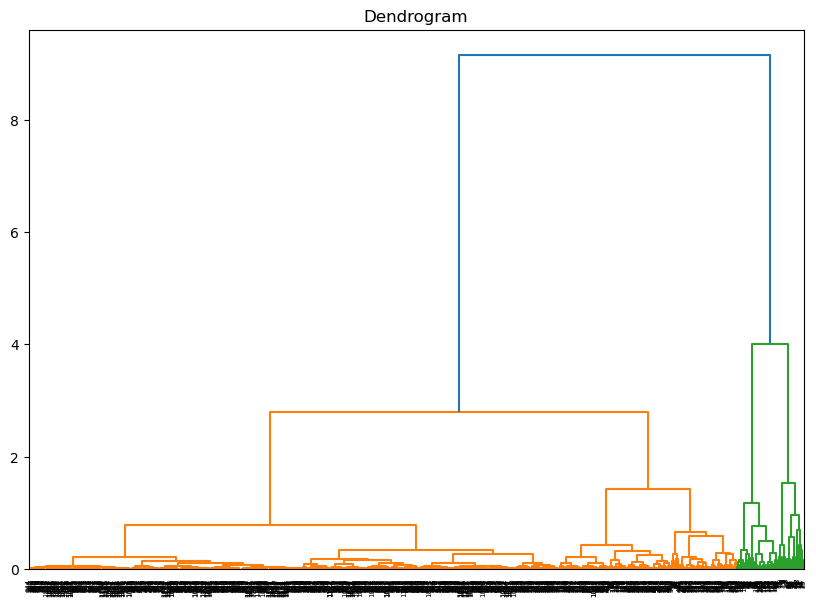

<Figure size 1000x700 with 0 Axes>

In [28]:
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

data_scaled = normalize(X_values)
data_scaled = pd.DataFrame(data_scaled, columns=X_values.columns)

print(data_scaled)
plt.figure(figsize=(10, 7))  
plt.title("Dendrogram")  
dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))

cluster = AgglomerativeClustering(n_clusters = 6, metric='euclidean', linkage='ward')  
cluster.fit_predict(data_scaled)

plt.figure(figsize=(10, 7))  
plt.scatter(data_scaled['X'], data_scaled['y'], c=cluster.labels_) 
plt.xlabel('X')
plt.ylabel('Y')

In [21]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Set a universal threshold for classification
threshold = 0.5

# Set up multiple models in a dictionary
models = {
    "logistic_regression": LogisticRegression(),
    "decision_tree": DecisionTreeClassifier(),
    "random_forest": RandomForestClassifier(),
    "k_nearest_neighbors": KNeighborsClassifier(),
    "support_vector_machine": SVC(),
    "gradient_boosting": GradientBoostingClassifier(),
    "naive_bayes": GaussianNB()
}

logistic_regression


/Users/lilawr/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


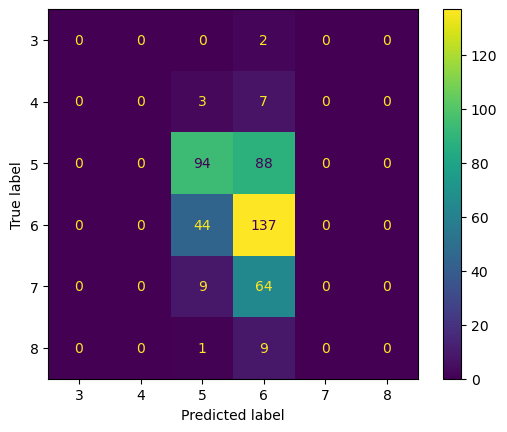

decision_tree


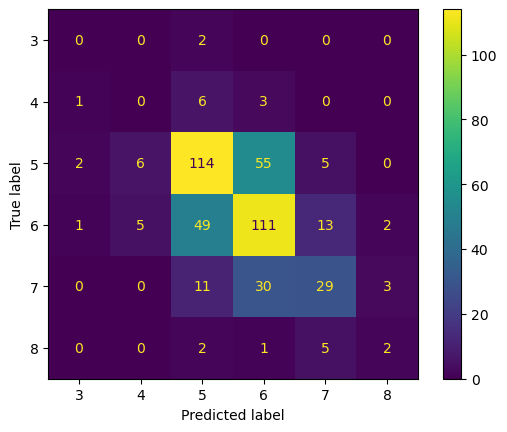

random_forest


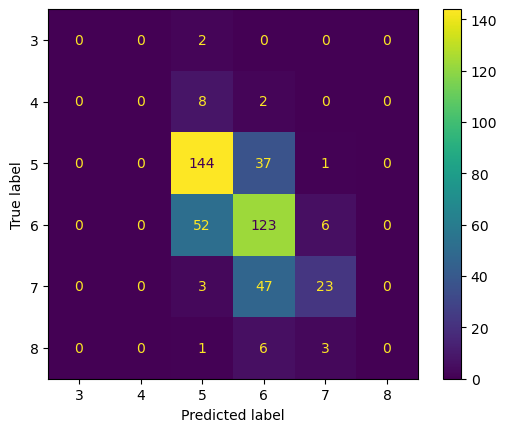

k_nearest_neighbors


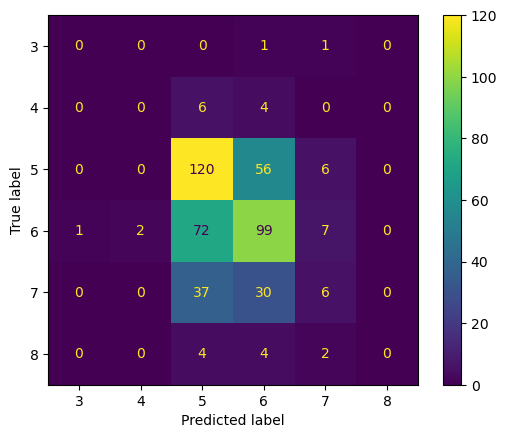

support_vector_machine


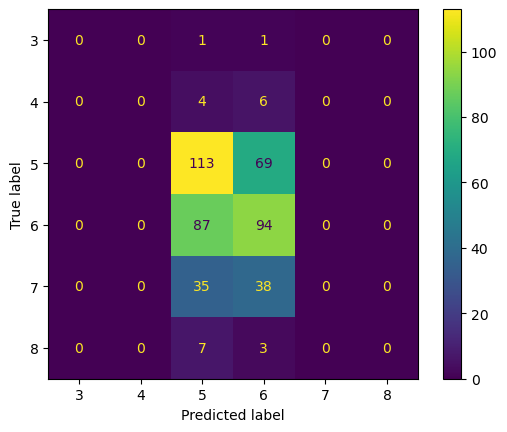

gradient_boosting


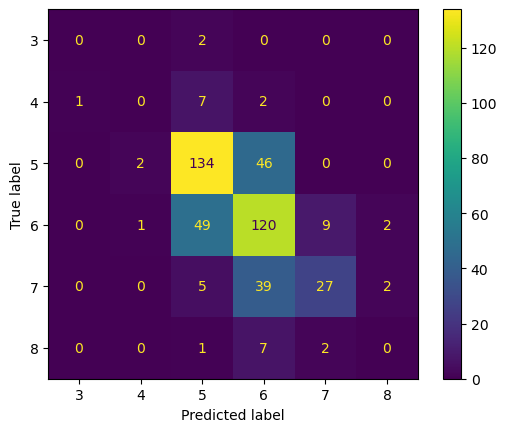

naive_bayes


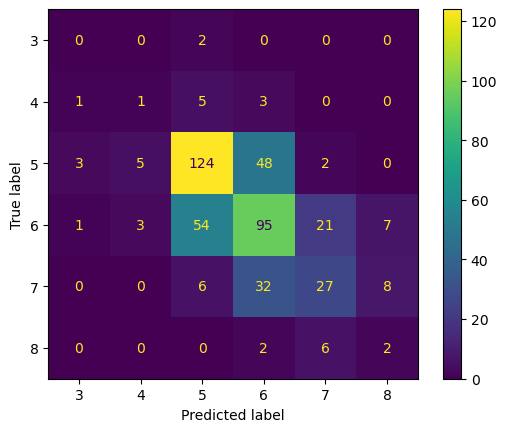

In [22]:
#def calc_accuracy(cm):
#    return sum(cm[i][i] for i in range(len(cm))) / sum(sum(row) for row in cm)

#def calc_miss_class_rate(cm):
#    return 1 - calc_accuracy(cm)

def accuracy_scores(cm):
    class_accuracies = np.diag(cm) / np.sum(cm, axis=1)
    return class_accuracies
    
#AKA true negative rate
def calc_specificity(cm):
    values = []
    for class_index in range(len(cm)):
        true_negatives = np.sum(np.delete(np.delete(cm, class_index, axis=0), class_index, axis=1))
        false_positives = np.sum(np.delete(cm[class_index, :], class_index))
        if (false_positives + true_negatives) == 0:
            specificity = 0
        else: 
            specificity = true_negatives / (true_negatives + false_positives)
        values.append(specificity)
    return values

def calc_precision(cm):
    precisions = []
    for i in range(len(cm)):
        true_positive = cm[i, i]
        false_positive = np.sum(cm[:, i]) - true_positive
        if (false_positive + true_positive) == 0:
            precision = 0
        else: 
            precision = true_positive / (true_positive + false_positive)
        precisions.append(precision)
    return precisions
    
#AKA recall
def calc_sensitivity(cm):
    values = []
    for class_index in range(len(cm)):
        true_positives = cm[class_index, class_index]
        false_negatives = np.sum(np.delete(cm[class_index, :], class_index))
        if (true_positives + false_negatives) == 0:
            specificity = 0
        else: 
            specificity = true_positives / (true_positives + false_negatives)
        values.append(specificity)
    return values

overall_results = []
raw_results = []

for key in models.keys():
    print(key)
   
    # 1 Fit the classifier model
    current_model = models[key]
    current_model.fit(X_train, y_train)
    
    #2 Prediction  on test set
    predictions = current_model.predict(X_test) 
    
    
    #3 Calculate some performance metrics to view and compare
    cm = confusion_matrix(y_test, predictions)
    #print(cm)
    
    #Filter the classes incase any are missing 
    test_classes = [x for x in current_model.classes_ if x in y_test.unique()]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_classes)
    precision_raw = calc_precision(cm)
    recall_raw = calc_sensitivity(cm)
    true_negative_rate_raw = calc_specificity(cm)
    
    overall_results.append({
        "model": key,
        "accuracy_score": accuracy_score(y_test, predictions),
        "precision": np.mean(precision_raw),
        "recall": np.mean(recall_raw),
        "true_negative_rate": np.mean(true_negative_rate_raw),
    })
    #print(pd.DataFrame(overall_results))
    
    raw_results.append({
        "model": key,
        "accuracy_raw": accuracy_scores(cm),
        "precision_raw": precision_raw,
        "recall_raw": recall_raw,
        "true_negative_rate_raw": true_negative_rate_raw,
        "test_class": test_classes
    })
    #print(pd.DataFrame(raw_results))
    
    disp.plot()
    plt.show()

In [23]:
overall_results_df = pd.DataFrame(overall_results)
overall_results_df.set_index('model', inplace=True)
overall_results_df = overall_results_df.sort_values(by=["accuracy_score"], ascending=False)
overall_results_df.head(len(models))

,accuracy_score,precision,recall,true_negative_rate
model,,,,
random_forest,0.633188,0.325796,0.297639,0.907068
gradient_boosting,0.613537,0.324674,0.294852,0.901247
decision_tree,0.558952,0.336329,0.306149,0.887936
naive_bayes,0.543668,0.314649,0.312674,0.886065
logistic_regression,0.504367,0.178128,0.212232,0.869090
k_nearest_neighbors,0.491266,0.214188,0.214749,0.867413
support_vector_machine,0.451965,0.150498,0.190036,0.852223


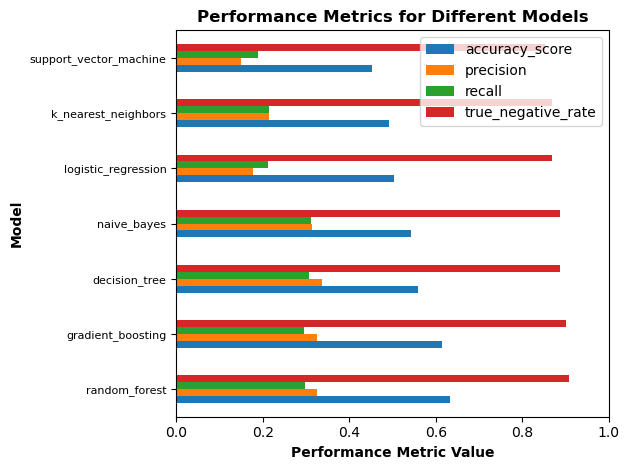

In [24]:
ax = overall_results_df.plot.barh()

plt.yticks(range(len(overall_results_df.index)), overall_results_df.index, fontsize=8)
plt.xlim(0.0, 1.0)

plt.xlabel('Performance Metric Value', fontweight='bold')
plt.ylabel('Model', fontweight='bold')
plt.title('Performance Metrics for Different Models', fontweight='bold')

plt.tight_layout()

In [49]:
results_exploded = [];
results_flattened = [];

for raw_result in raw_results:
    for idx, class_name in enumerate(raw_result["test_class"]):
        results_exploded.append({
            "model": raw_result["model"],
            "class_name": class_name,
            "accuracy": raw_result["accuracy_raw"][idx],
            "precision": raw_result["precision_raw"][idx],
            "recall": raw_result["recall_raw"][idx],
            "true_negative_rate": raw_result["true_negative_rate_raw"][idx],
        })
    
overall_class_results_df = pd.DataFrame(results_exploded)
overall_class_results_df.head(20)
overall_class_results_df = overall_class_results_df.sort_values(by=["accuracy"], ascending=False)

grouped_raw_results = overall_class_results_df.groupby(["class_name", "model"]).agg({
    "accuracy": 'mean',
    "precision": 'mean',
    "recall": 'mean',
    "true_negative_rate": 'mean'
})
grouped_raw_results


accuracy  precision    recall  \
class_name model                                                   
3          decision_tree           0.000000   0.000000  0.000000   
           gradient_boosting       0.000000   0.000000  0.000000   
           k_nearest_neighbors     0.000000   0.000000  0.000000   
           logistic_regression     0.000000   0.000000  0.000000   
           naive_bayes             0.000000   0.000000  0.000000   
           random_forest           0.000000   0.000000  0.000000   
           support_vector_machine  0.000000   0.000000  0.000000   
4          decision_tree           0.000000   0.000000  0.000000   
           gradient_boosting       0.000000   0.000000  0.000000   
           k_nearest_neighbors     0.000000   0.000000  0.000000   
           logistic_regression     0.000000   0.000000  0.000000   
           naive_bayes             0.100000   0.111111  0.100000   
           random_forest           0.000000   0.000000  0.000000   
           support_vector_machine  0.000000   0.000000  0.000000   
5          decision_tree           0.626374   0.619565  0.626374   
           gradient_boosting       0.736264   0.676768  0.736264   
           k_nearest_neighbors     0.659341   0.502092  0.659341   
           logistic_regression     0.516484   0.622517  0.516484   
           naive_bayes             0.681319   0.649215  0.681319   
           random_forest           0.791209   0.685714  0.791209   
           support_vector_machine  0.620879   0.457490  0.620879   
6          decision_tree           0.613260   0.555000  0.613260   
           gradient_boosting       0.662983   0.560748  0.662983   
           k_nearest_neighbors     0.546961   0.510309  0.546961   
           logistic_regression     0.756906   0.446254  0.756906   
           naive_bayes             0.524862   0.527778  0.524862   
           random_forest           0.679558   0.572093  0.679558   
           support_vector_machine  0.519337   0.445498  0.519337   
7          decision_tree           0.397260   0.557692  0.397260   
           gradient_boosting       0.369863   0.710526  0.369863   
           k_nearest_neighbors     0.082192   0.272727  0.082192   
           logistic_regression     0.000000   0.000000  0.000000   
           naive_bayes             0.369863   0.482143  0.369863   
           random_forest           0.315068   0.696970  0.315068   
           support_vector_machine  0.000000   0.000000  0.000000   
8          decision_tree           0.200000   0.285714  0.200000   
           gradient_boosting       0.000000   0.000000  0.000000   
           k_nearest_neighbors     0.000000   0.000000  0.000000   
           logistic_regression     0.000000   0.000000  0.000000   
           naive_bayes             0.200000   0.117647  0.200000   
           random_forest           0.000000   0.000000  0.000000   
           support_vector_machine  0.000000   0.000000  0.000000   

                                   true_negative_rate  
class_name model                                       
3          decision_tree                     0.995595  
           gradient_boosting                 0.995624  
           k_nearest_neighbors               0.995624  
           logistic_regression               0.995633  
           naive_bayes                       0.995585  
           random_forest                     0.995633  
           support_vector_machine            0.995633  
4          decision_tree                     0.977629  
           gradient_boosting                 0.978022  
           k_nearest_neighbors               0.978070  
           logistic_regression               0.978166  
           naive_bayes                       0.979955  
           random_forest                     0.978166  
           support_vector_machine            0.978166  
5          decision_tree                     0.751825  
           gradient_boosting                 0.815385  
           k_nearest_neighbors    

Text(0.5, 1.0, 'Performance Metrics for Different Models')

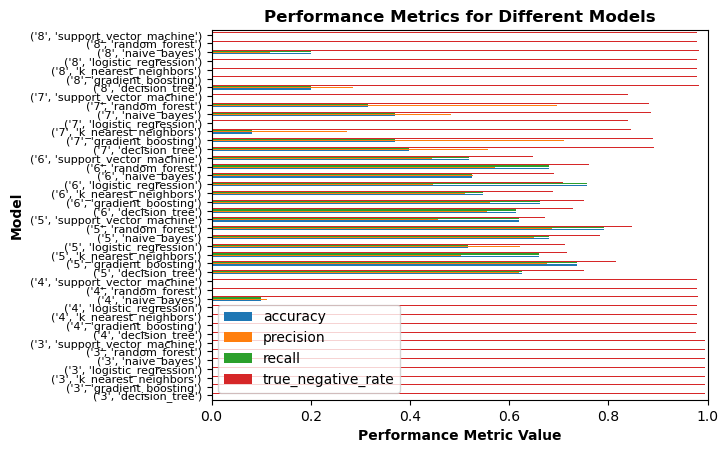

In [50]:
ax = grouped_raw_results.plot.barh()
plt.yticks(range(len(grouped_raw_results.index)), grouped_raw_results.index, fontsize=8)
plt.xlim(0.0, 1.0)
plt.xlabel('Performance Metric Value', fontweight='bold')
plt.ylabel('Model', fontweight='bold')
plt.title('Performance Metrics for Different Models', fontweight='bold')


# Testing different models on the data
<a class="anchor" id="parameter-tuning"></a>